In [145]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
from PIL import Image
import torch.optim as optim
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

In [146]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    # 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    # 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    # 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    # 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [147]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [148]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # 1×1×64
        self.max_pool = nn.AdaptiveMaxPool2d(1) # 1×1×64

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False), # 1×1×4
                               nn.ReLU(), # 1×1×4
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)) # 1×1×64
        self.sigmoid = nn.Sigmoid() # 1×1×64

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x)) # 1×1×64
        max_out = self.fc(self.max_pool(x)) # 1×1×64
        out = avg_out + max_out # 1×1×64
        return self.sigmoid(out) # 1×1×64

In [149]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # 56×56×1
        max_out, _ = torch.max(x, dim=1, keepdim=True) # 56×56×1
        x = torch.cat([avg_out, max_out], dim=1) # 56×56×2
        x = self.conv1(x) # 56×56×1
        return self.sigmoid(x) # 56×56×1

In [150]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride) # 56*56*64 
        self.bn1 = nn.BatchNorm2d(planes) # 56*56*64 
        self.relu = nn.ReLU(inplace=True) # 56*56*64 
        self.conv2 = conv3x3(planes, planes) # 56*56*64 
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x # 56×56×64, 56×56×64, 56×56×64, 28x28x128

        out = self.conv1(x) # 56*56*64, 56×56×64, 28*28*128, 28*28*128
        out = self.bn1(out) # 56*56*64, 56×56×64, 28*28*128, 28*28*128
        out = self.relu(out) # 56*56*64, 56×56×64, 28*28*128, 28*28*128

        out = self.conv2(out) # 56*56*64, 56×56×64, 28*28*128, 28*28*128
        out = self.bn2(out) # 56*56*64, 56×56×64, 28*28*128, 28*28*128

        out = self.ca(out) * out # (1*1*64) * (56*56*64) = 56*56*64; 56×56×64; 28*28*128; 28*28*128
        out = self.sa(out) * out # (56×56×1) * (56×56×64) = 56×56×64; 56×56×64; 28x28x128; 28*28*128

        if self.downsample is not None:
            residual = self.downsample(x) # 28*28*128, 

        out += residual # 56×56×64, 56×56×64, 28*28*128, 28*28*128
        out = self.relu(out) # 56×56×64, 56×56×64, 28*28*128, 28*28*128

        return out

In [151]:
class PatchExtraction(nn.Module):
    def __init__(self):
        super(PatchExtraction, self).__init__()
        
        # First separable convolution (depthwise + pointwise)
        self.depthwise_conv1 = nn.Conv2d(128, 128, kernel_size=4, stride=4, padding=1, groups=128)  # Input: 28*28*128, Output: 7*7*128
        self.pointwise_conv1 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)  # Output: 7*7*128
        
        # Second separable convolution (depthwise + pointwise)
        self.depthwise_conv2 = nn.Conv2d(128, 128, kernel_size=2, stride=2, padding=0, groups=128)  # Output: 3×3×128
        self.pointwise_conv2 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)  # Output: 3×3×128

        # Normal Conv (used directly)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)  # Output: 3×3×128

    def forward(self, x):
        # First separable convolution
        x = F.relu(self.depthwise_conv1(x))
        x = F.relu(self.pointwise_conv1(x))

        # Second separable convolution
        x = F.relu(self.depthwise_conv2(x))
        x = F.relu(self.pointwise_conv2(x))

        # Normal convolution
        x = F.relu(self.conv3(x))
        
        return x

In [152]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_heads, num_classes=7):
        self.inplanes = 64
        # self.embed_dim = embed_dim
        self.num_heads = num_heads
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False) # 112*112*64
        self.bn1 = nn.BatchNorm2d(64) # 112*112*64
        self.relu = nn.ReLU(inplace=True) # 112*112*64
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 56*56*64
        self.layer1 = self._make_layer(block, 64, layers[0]) # 56×56×64
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # 28*28*128
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.patch_extraction = PatchExtraction() # 3*3*128
        self.global_avg_pool1 = nn.AdaptiveAvgPool2d(1)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.attention = nn.MultiheadAttention(128, num_heads)
        # Input will be changed to the size 9x32x128 (see below forward code) which will be used as query key value 
        # weight matrix will have the size 128*(128) as default value (128) is default value we can change this by using vdim and kdim attributes of the class
        # else weight matrix will have embed_dim * kdim for key matrix , after multiplying 9x32x128 will be the ouptut like this we will be3 having key query 
        # value matrix (Q)x(K.T)  query and key transpose multiplication will produce of size 9x32x9 and dividing it with sqrt(128) , this diving saves the 
        # variance and it gets trained with gradient saturation and finally it applies soft max on to this making each row value sum up to 1 of 9x9 matrix 
        # this for 32 batch size and multiplying it with 9x32x128 i.e 9x32x9 with 9x32x128 value matrix outputs the matrix 9x32x128
        self.layer_norm = nn.LayerNorm(128)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear1 = nn.Linear(128,64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5) 
        self.classifier = nn.Linear(64, num_classes)
#         nn.Sequential(
#             nn.Linear(256,128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )

        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                fan_out = m.weight.size(0)  # fan-out
                fan_in = m.weight.size(1) if m.weight.dim() > 1 else 0  # fan-in
                init_range = 1.0 / math.sqrt(fan_in + fan_out)
                m.weight.data.uniform_(-init_range, init_range)
                if m.bias is not None:
                    m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False), # 28*28*128
                nn.BatchNorm2d(planes * block.expansion), # 28*28*128
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
#         x = self.layer3(x)
        # x = self.layer4(x)

        x = self.patch_extraction(x) 
        x = self.global_avg_pool1(x)
#         x = x.view(x.size(0), -1)
        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, height*width).permute(2,0,1)

        query = x
        key = x
        value = x

        attn_output, _ = self.attention(query, key, value)
        x = self.layer_norm(attn_output + x)
        x = x.permute(0,2,1).view(batch_size, channels, height, width)
        # x = nn.functional.adaptive_avg_pool2d(x,1).view(batch_size, -1)
        x = self.global_avg_pool(x).view(batch_size, -1)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        logits = self.classifier(x)

        return logits

In [153]:
# def freeze_layers_until(layer_names, model):
#     """
#     Freezes the parameters of layers up to a certain point in the model.
    
#     :param layer_names: List of layer names to freeze.
#     :param model: The model whose layers should be frozen.
#     """
#     for name, param in model.named_parameters():
#         if any(layer in name for layer in layer_names):
#             param.requires_grad = True

In [155]:
def resnet18_cbam(pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    num_heads = 1
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_heads)
#     if pretrained:
#         pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
#         now_state_dict        = model.state_dict()
#         now_state_dict.update(pretrained_state_dict)
#         model.load_state_dict(now_state_dict, strict=False)
    
    # New Code Starts From Here
    if pretrained:
        checkpoint = torch.load(r"/kaggle/working/models/epoch_32_acc_82.24_PE_aug_1head_unfreeze_tot20epoch_4heads.pth")
        model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    # Ends Here

    
    return model

In [156]:
model = resnet18_cbam()


/tmp/ipykernel_30/63054293.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"/kaggle/working/models/epoch_32_acc_82.24_PE_aug_1head_unfreeze_tot

In [157]:
# freeze_layers_until(['conv1', 'bn1', 'layer1', 'layer2'], model)

In [158]:
def check_frozen_layers(model):
    """
    Prints whether the parameters in each layer are frozen (requires_grad=False).
    
    :param model: The model whose layers' freezing status is being checked.
    """
    for name, param in model.named_parameters():
        print(f"Layer: {name} | Frozen: {not param.requires_grad}")
check_frozen_layers(model)

Layer: conv1.weight | Frozen: False
Layer: bn1.weight | Frozen: False
Layer: bn1.bias | Frozen: False
Layer: layer1.0.conv1.weight | Frozen: False
Layer: layer1.0.bn1.weight | Frozen: False
Layer: layer1.0.bn1.bias | Frozen: False
Layer: layer1.0.conv2.weight | Frozen: False
Layer: layer1.0.bn2.weight | Frozen: False
Layer: layer1.0.bn2.bias | Frozen: False
Layer: layer1.0.ca.fc.0.weight | Frozen: False
Layer: layer1.0.ca.fc.2.weight | Frozen: False
Layer: layer1.0.sa.conv1.weight | Frozen: False
Layer: layer1.1.conv1.weight | Frozen: False
Layer: layer1.1.bn1.weight | Frozen: False
Layer: layer1.1.bn1.bias | Frozen: False
Layer: layer1.1.conv2.weight | Frozen: False
Layer: layer1.1.bn2.weight | Frozen: False
Layer: layer1.1.bn2.bias | Frozen: False
Layer: layer1.1.ca.fc.0.weight | Frozen: False
Layer: layer1.1.ca.fc.2.weight | Frozen: False
Layer: layer1.1.sa.conv1.weight | Frozen: False
Layer: layer2.0.conv1.weight | Frozen: False
Layer: layer2.0.bn1.weight | Frozen: False
Layer: lay

In [159]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [160]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [161]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [183]:
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Class Labels are 0-Indexed CAREFULL

In [163]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Read the CSV file
        self.data_frame = pd.read_csv(csv_file)

        # Ensure the CSV file has columns 'filename' and 'class'
        assert 'image' in self.data_frame.columns
        assert 'label' in self.data_frame.columns

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get the filename and class label
        img_name = self.data_frame.iloc[idx, 0]  # Get the filename from the CSV
        class_label = self.data_frame.iloc[idx, 1] - 1  # Get the class label from the CSV

        # Construct the path to the image based on its class label
        class_folder = os.path.join(self.image_dir, str(class_label+1))  # Convert class label to string
        img_path = os.path.join(class_folder, img_name)

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, class_label

In [164]:
image_directory = r"/kaggle/input/raf-db-dataset/DATASET/train"  # Directory containing class subfolders
csv_file_path = r"/kaggle/input/raf-db-dataset/train_labels.csv"

In [165]:
train_dataset = CustomImageDataset(image_dir=image_directory, csv_file=csv_file_path, transform=transform)

In [184]:
aug_train_dataset = CustomImageDataset(image_directory, csv_file_path, aug_transform)

In [167]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, pin_memory=True, shuffle=True)

In [185]:
aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, num_workers=4, pin_memory=True, shuffle=True)

In [173]:
torch.cuda.empty_cache()

In [174]:
# checkpoint = torch.load(r"/kaggle/working/models/epoch_19_acc_79.73_PE_aug_1head_unfreeze_tot20epoch_4heads.pth")

In [182]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [176]:
os.makedirs('models', exist_ok=True)

In [177]:
os.getcwd()

'/kaggle/working'

In [178]:
test_image_directory = r"/kaggle/input/raf-db-dataset/DATASET/test"
test_csv_file_path = r"/kaggle/input/raf-db-dataset/test_labels.csv"

In [179]:
test_dataset = CustomImageDataset(test_image_directory, test_csv_file_path, transform)

In [180]:
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True, shuffle=True)

In [186]:
def train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=20):
    # train_loader = pl.MpDeviceLoader(train_loader, device)
    best_accuracy = 0
    model.train()
    # os.makedirs('models', exist_ok=True)
    for epoch in range(1, num_epochs+1):
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs=model(images)
            loss = criterion(outputs,labels)

            loss.backward()
            optimizer.step()
            # xm.optimizer_step(optimizer)

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}')
        if epoch > 1 :
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in tqdm(test_loader):
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    logits = model(images)
                    
                    _, predicted = torch.max(logits, 1)
                    total += labels.size(0)  # Add the batch size to total
                    correct += (predicted == labels).sum().item()
            accuracy = 100*(correct/total)
            print(f"test_Acc : {accuracy}")
                
            if accuracy > best_accuracy or epoch==20:
                best_accuracy = accuracy
                torch.save({'iter': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),},
                        os.path.join('models', f"epoch_{epoch}_acc_{accuracy:.2f}_PE_naug_1head_unfreeze_tot20epoch_4heads.pth"))
                print('Model saved.')
            model.train()

In [187]:
# train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=20)

In [188]:
train(model, aug_train_loader, test_loader, criterion, optimizer, device, num_epochs=40)

100%|██████████| 384/384 [00:49<00:00,  7.82it/s]


Epoch [1/40], Loss: 0.5514


100%|██████████| 384/384 [00:45<00:00,  8.51it/s]


Epoch [2/40], Loss: 0.4996


100%|██████████| 96/96 [00:04<00:00, 21.38it/s]


test_Acc : 80.89960886571056
Model saved.


100%|██████████| 384/384 [00:45<00:00,  8.53it/s]


Epoch [3/40], Loss: 0.4889


100%|██████████| 96/96 [00:04<00:00, 22.16it/s]


test_Acc : 79.10691003911343


100%|██████████| 384/384 [00:45<00:00,  8.41it/s]


Epoch [4/40], Loss: 0.4679


100%|██████████| 96/96 [00:03<00:00, 24.57it/s]


test_Acc : 73.79400260756192


100%|██████████| 384/384 [00:46<00:00,  8.33it/s]


Epoch [5/40], Loss: 0.4615


100%|██████████| 96/96 [00:03<00:00, 24.82it/s]


test_Acc : 78.16166883963494


100%|██████████| 384/384 [00:45<00:00,  8.43it/s]


Epoch [6/40], Loss: 0.4624


100%|██████████| 96/96 [00:03<00:00, 24.60it/s]


test_Acc : 78.48761408083442


100%|██████████| 384/384 [00:45<00:00,  8.43it/s]


Epoch [7/40], Loss: 0.4533


100%|██████████| 96/96 [00:03<00:00, 25.06it/s]


test_Acc : 79.46544980443285


100%|██████████| 384/384 [00:44<00:00,  8.57it/s]


Epoch [8/40], Loss: 0.4401


100%|██████████| 96/96 [00:03<00:00, 24.95it/s]


test_Acc : 76.27118644067797


100%|██████████| 384/384 [00:45<00:00,  8.47it/s]


Epoch [9/40], Loss: 0.4373


100%|██████████| 96/96 [00:03<00:00, 24.44it/s]


test_Acc : 77.50977835723599


100%|██████████| 384/384 [00:44<00:00,  8.60it/s]


Epoch [10/40], Loss: 0.4207


100%|██████████| 96/96 [00:03<00:00, 24.90it/s]


test_Acc : 79.5632333767927


100%|██████████| 384/384 [00:45<00:00,  8.43it/s]


Epoch [11/40], Loss: 0.4169


100%|██████████| 96/96 [00:04<00:00, 23.91it/s]


test_Acc : 77.21642764015645


100%|██████████| 384/384 [00:46<00:00,  8.24it/s]


Epoch [12/40], Loss: 0.4219


100%|██████████| 96/96 [00:03<00:00, 24.16it/s]


test_Acc : 79.98696219035202


100%|██████████| 384/384 [00:47<00:00,  8.14it/s]


Epoch [13/40], Loss: 0.4129


100%|██████████| 96/96 [00:04<00:00, 23.84it/s]


test_Acc : 79.75880052151238


100%|██████████| 384/384 [00:46<00:00,  8.29it/s]


Epoch [14/40], Loss: 0.3978


100%|██████████| 96/96 [00:03<00:00, 24.47it/s]


test_Acc : 76.14080834419818


100%|██████████| 384/384 [00:46<00:00,  8.26it/s]


Epoch [15/40], Loss: 0.3977


100%|██████████| 96/96 [00:03<00:00, 24.36it/s]


test_Acc : 76.82529335071709


100%|██████████| 384/384 [00:44<00:00,  8.55it/s]


Epoch [16/40], Loss: 0.3923


100%|██████████| 96/96 [00:04<00:00, 23.27it/s]


test_Acc : 79.30247718383312


100%|██████████| 384/384 [00:45<00:00,  8.40it/s]


Epoch [17/40], Loss: 0.3719


100%|██████████| 96/96 [00:03<00:00, 25.35it/s]


test_Acc : 78.94393741851368


100%|██████████| 384/384 [00:44<00:00,  8.56it/s]


Epoch [18/40], Loss: 0.3796


100%|██████████| 96/96 [00:03<00:00, 24.95it/s]


test_Acc : 72.16427640156454


100%|██████████| 384/384 [00:45<00:00,  8.46it/s]


Epoch [19/40], Loss: 0.3812


100%|██████████| 96/96 [00:03<00:00, 24.73it/s]


test_Acc : 78.748370273794


100%|██████████| 384/384 [00:44<00:00,  8.55it/s]


Epoch [20/40], Loss: 0.3628


100%|██████████| 96/96 [00:04<00:00, 23.46it/s]


test_Acc : 77.8031290743155
Model saved.


100%|██████████| 384/384 [00:44<00:00,  8.54it/s]


Epoch [21/40], Loss: 0.3804


100%|██████████| 96/96 [00:03<00:00, 24.52it/s]


test_Acc : 77.83572359843546
Model saved.


100%|██████████| 384/384 [00:44<00:00,  8.62it/s]


Epoch [22/40], Loss: 0.3665


100%|██████████| 96/96 [00:03<00:00, 24.01it/s]


test_Acc : 78.42242503259452
Model saved.


100%|██████████| 384/384 [00:44<00:00,  8.55it/s]


Epoch [23/40], Loss: 0.3683


100%|██████████| 96/96 [00:03<00:00, 25.03it/s]


test_Acc : 79.75880052151238
Model saved.


100%|██████████| 384/384 [00:44<00:00,  8.56it/s]


Epoch [24/40], Loss: 0.3535


100%|██████████| 96/96 [00:04<00:00, 23.49it/s]


test_Acc : 76.01043024771839


100%|██████████| 384/384 [00:45<00:00,  8.49it/s]


Epoch [25/40], Loss: 0.3612


100%|██████████| 96/96 [00:03<00:00, 24.94it/s]


test_Acc : 77.34680573663624


100%|██████████| 384/384 [00:45<00:00,  8.50it/s]


Epoch [26/40], Loss: 0.3523


100%|██████████| 96/96 [00:04<00:00, 22.37it/s]


test_Acc : 77.73794002607562


100%|██████████| 384/384 [00:45<00:00,  8.53it/s]


Epoch [27/40], Loss: 0.3470


100%|██████████| 96/96 [00:04<00:00, 23.96it/s]


test_Acc : 76.79269882659713


100%|██████████| 384/384 [00:45<00:00,  8.52it/s]


Epoch [28/40], Loss: 0.3440


100%|██████████| 96/96 [00:04<00:00, 22.31it/s]


test_Acc : 78.748370273794


100%|██████████| 384/384 [00:44<00:00,  8.56it/s]


Epoch [29/40], Loss: 0.3365


100%|██████████| 96/96 [00:03<00:00, 24.62it/s]


test_Acc : 77.57496740547587


100%|██████████| 384/384 [00:44<00:00,  8.57it/s]


Epoch [30/40], Loss: 0.3443


100%|██████████| 96/96 [00:04<00:00, 22.33it/s]


test_Acc : 79.92177314211213
Model saved.


100%|██████████| 384/384 [00:44<00:00,  8.58it/s]


Epoch [31/40], Loss: 0.3317


100%|██████████| 96/96 [00:03<00:00, 24.30it/s]


test_Acc : 78.38983050847457


100%|██████████| 384/384 [00:44<00:00,  8.59it/s]


Epoch [32/40], Loss: 0.3172


100%|██████████| 96/96 [00:04<00:00, 22.29it/s]


test_Acc : 73.3702737940026


100%|██████████| 384/384 [00:44<00:00,  8.62it/s]


Epoch [33/40], Loss: 0.3309


100%|██████████| 96/96 [00:03<00:00, 25.09it/s]


test_Acc : 79.98696219035202
Model saved.


100%|██████████| 384/384 [00:44<00:00,  8.59it/s]


Epoch [34/40], Loss: 0.3286


100%|██████████| 96/96 [00:04<00:00, 22.57it/s]


test_Acc : 79.82398956975229


100%|██████████| 384/384 [00:44<00:00,  8.55it/s]


Epoch [35/40], Loss: 0.3024


100%|██████████| 96/96 [00:03<00:00, 25.07it/s]


test_Acc : 76.10821382007823


100%|██████████| 384/384 [00:44<00:00,  8.55it/s]


Epoch [36/40], Loss: 0.3289


100%|██████████| 96/96 [00:04<00:00, 22.33it/s]


test_Acc : 79.6284224250326


100%|██████████| 384/384 [00:44<00:00,  8.59it/s]


Epoch [37/40], Loss: 0.3170


100%|██████████| 96/96 [00:03<00:00, 24.51it/s]


test_Acc : 79.26988265971316


100%|██████████| 384/384 [00:48<00:00,  7.85it/s]


Epoch [38/40], Loss: 0.3136


100%|██████████| 96/96 [00:03<00:00, 24.76it/s]


test_Acc : 76.59713168187744


100%|██████████| 384/384 [00:45<00:00,  8.52it/s]


Epoch [39/40], Loss: 0.3111


100%|██████████| 96/96 [00:03<00:00, 24.92it/s]


test_Acc : 79.367666232073


100%|██████████| 384/384 [00:45<00:00,  8.43it/s]


Epoch [40/40], Loss: 0.3010


100%|██████████| 96/96 [00:03<00:00, 25.05it/s]

test_Acc : 79.82398956975229


In [158]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)  # Add the batch size to total
        correct += (predicted == labels).sum().item()
accuracy = 100*(correct/total)




accuracy


100%|██████████| 96/96 [00:07<00:00, 13.21it/s]


77.02086049543678

In [ ]:
test_image_directory = r"/kaggle/input/raf-db-dataset/DATASET/test"
test_csv_file_path = r"/kaggle/input/raf-db-dataset/test_labels.csv"

In [37]:
test_dataset = CustomImageDataset(test_image_directory, test_csv_file_path, transform)

In [38]:
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=False)

In [46]:
# for file in os.listdir(r"/kaggle/working/models") :
#     checkpoint = torch.load(os.path.join(r"/kaggle/working/models",file))
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
#     all_preds=[]
#     all_labels=[]
#     with torch.no_grad():
#         for images, labels in tqdm(test_loader):
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs,1)
#     #         predicted+=1

#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     all_preds = np.array(all_preds)
#     all_labels = np.array(all_labels)
    
#     accuracy = accuracy_score(all_labels, all_preds)
    
#     print(f'accuracy: {accuracy:.4f} for {file}')

In [47]:
checkpoint = torch.load(r"/kaggle/working/models/tot20epoch_4heads_epoch_13_loss_0.07219641906097725.pth")

/tmp/ipykernel_30/846673855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

  checkpoint = torch.load(r"/kaggle/working/models/tot20epoch_4heads_epoch_13_loss_0.072196419

In [48]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [49]:
all_preds=[]
all_labels=[]
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
#         predicted+=1
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████| 96/96 [00:14<00:00,  6.45it/s]


In [50]:
accuracy = accuracy_score(all_labels, all_preds)
accuracy

0.7666232073011734

In [52]:
cm = confusion_matrix(all_labels, all_preds)
cm

array([[ 247,   12,    2,   12,    6,    4,   46],
       [  16,   30,    3,   12,    2,    2,    9],
       [   4,    3,   63,   14,   14,   12,   50],
       [   6,    2,    8, 1061,   13,    1,   94],
       [   4,    2,   12,   45,  302,    5,  108],
       [   8,    2,   23,   16,    6,   88,   19],
       [  26,    0,    7,   32,   49,    5,  561]])

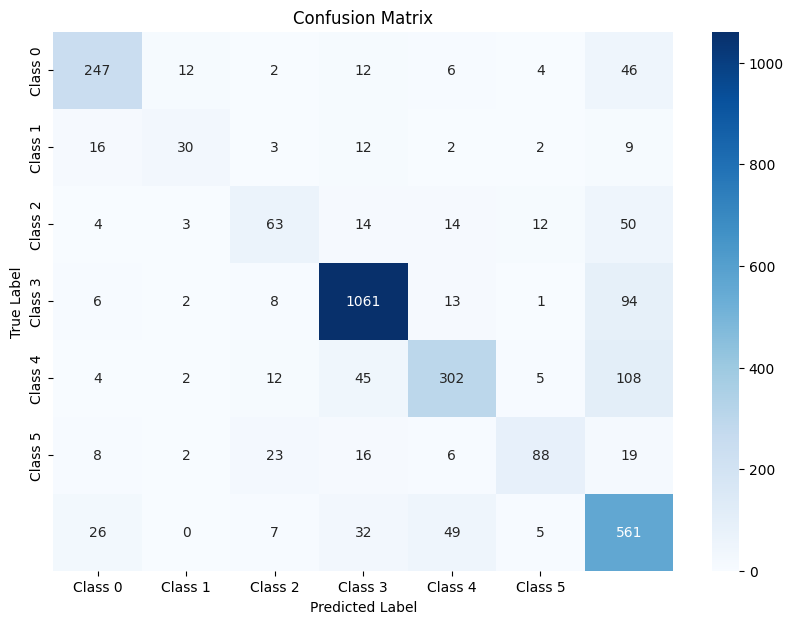

In [55]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(6)], yticklabels=[f'Class {i}' for i in range(6)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()